In [1]:
import os, time, sys
import numpy as np
import torch
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import minimize
from tqdm import tqdm

device = "cuda"
SWITCH_LOSS_EPOCH = 5

# Load csv

In [2]:
# train_root = "./dataset/train_images/"
# for idx,name in enumerate(os.listdir(train_root)):
#     if idx==0:
#         img = Image.open("{}/{}".format(train_root,name))
#         fig,axes = plt.subplots(1,1,figsize=(8,10))
#         axes.imshow(img)
#         plt.pause(.1)

In [3]:
PATH = "./dataset/"
train = pd.read_csv(PATH + 'train_shuf_remove.csv')
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)
train.head(1)

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...


# Show distribution

Text(0.5, 0, 'Number of cars in image')

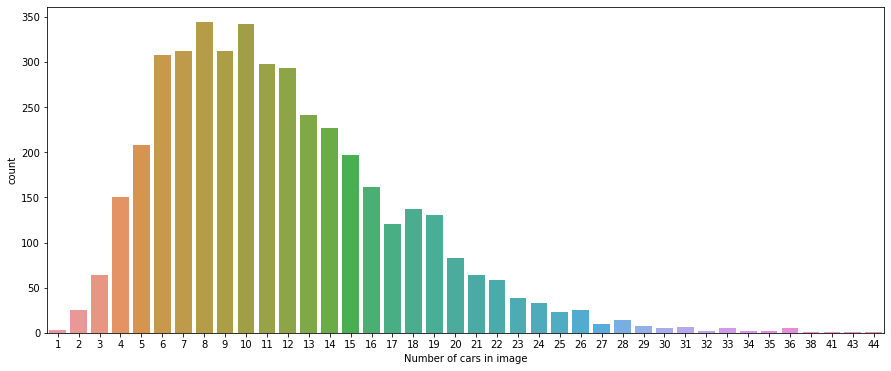

In [4]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''

    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        coords[-1]['id'] = int(coords[-1]['id'])
    return coords

# input_s = "16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339"
# str2coords(input_s)
lens = [len(str2coords(s)) for s in train['PredictionString']]
plt.figure(figsize=(15,6))
seaborn.countplot(lens);
plt.xlabel('Number of cars in image')

In [5]:
# points_df = pd.DataFrame()
# for col in ['x', 'y', 'z', 'yaw', 'pitch', 'roll']:
#     arr = []
#     for ps in train['PredictionString']:
#         coords = str2coords(ps)
#         arr += [c[col] for c in coords]
#     points_df[col] = arr
# print('len(points_df)', len(points_df))
# points_df.head(2)

# 2d Visualization

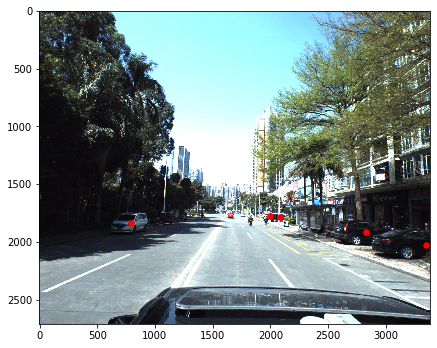

In [6]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image (row)
        ys: y coordinates in the image (column)
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys


train_root = "./dataset/train_images/"
for idx,_ in enumerate(os.listdir(train_root)):
    if idx<1:
        name = train['ImageId'][idx]
        img = Image.open("{}/{}.jpg".format(train_root,name))
        coordinate = get_img_coords(train['PredictionString'][idx])
#         print(coordinate)
        fig,axes = plt.subplots(1,1,figsize=(7,7))
        axes.imshow(img)
        axes.scatter(*coordinate,color='red',s=30)
        plt.pause(.1)
    else:
        break

# 3d Visualization

In [7]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image

def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
#         cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
        cv2.circle(image, (p_x, p_y), int(30), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image

def cv_read(file_name,fast_mode=False):
    img = cv2.imread(file_name)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        
#         print(Rt)
#         print(t)
        
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]

#         print(Rt)
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    return img

# train_root = "./dataset/train_images/"
# for idx,_ in enumerate(os.listdir(train_root)):
#     if idx<1:
#         name = train['ImageId'][idx]
#         img = cv_read("{}/{}.jpg".format(train_root,name))
#         coordinate = str2coords(train['PredictionString'].iloc[idx])
#         pose_info = visualize(img,coordinate)

#         print(np.shape(img))
#         fig,axes = plt.subplots(1,2,figsize=(12,12))
#         axes[0].imshow(img)
#         img_vis = visualize(img, str2coords(train['PredictionString'].iloc[idx]))
#         axes[1].imshow(img_vis)
#         plt.pause(.1)
#     else:
#         break
    

# Image preprocessing

In [8]:
# IMG_WIDTH = 1024
# IMG_HEIGHT = IMG_WIDTH // 16 * 5
# MODEL_SCALE = 8

# IMG_WIDTH = 2048
# IMG_HEIGHT = IMG_WIDTH // 4

IMG_WIDTH = 512
IMG_HEIGHT = 512
MODEL_SCALE = 8

def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

def rotate(x, angle): 
    x = x + angle 
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi 
    return x

def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')

def get_mask_and_regr(img, labels):
    #img -> raw image size
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)  #list of dict (car_num,7) -> dict: ['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']
    xs, ys = get_img_coords(labels)  #both shapes are (car_num,)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        if x >= 0 and x < IMG_HEIGHT // MODEL_SCALE and y >= 0 and y < IMG_WIDTH // MODEL_SCALE:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

In [ ]:
PATH = './dataset/'
img = imread(PATH + 'train_images/' + train['ImageId'][0] + '.jpg')
img_pre = preprocess_image(img)
mask, regr = get_mask_and_regr(img, train['PredictionString'][0])

print('img.shape', img.shape, 'std:', np.std(img_pre))
print('mask.shape', mask.shape, 'std:', np.std(mask))
print('regr.shape', regr.shape, 'std:', np.std(regr))

size = 8

plt.figure(figsize=(size,size))
plt.title('Processed image')
plt.imshow(img_pre)
plt.show()

plt.figure(figsize=(size,size))
plt.title('Detection Mask')
plt.imshow(mask)
plt.show()

plt.figure(figsize=(size,size))
plt.title('Yaw values')
plt.imshow(regr[:,:,-2])
plt.show()

# Transform and Dataloader 

In [10]:
from imgaug import augmenters as iaa
# from imgaug.augmentables.segmaps import SegmentationMapOnImage
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
#         iaa.Scale((640, 480)),
#         iaa.Fliplr(0.5),
        iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 1.5))),
#         iaa.Sometimes(0.1, iaa.AverageBlur(1.2)),
#         iaa.Sometimes(1, iaa.Affine(rotate=(-20, 20),order=[0, 1],translate_px={"x":(-2, 2),"y":(-2,2)},mode='symmetric')),
#         iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.25))),
#         iaa.Sometimes(0.1, iaa.SaltAndPepper(0.05,False)),
#         iaa.Invert(0.5),
#         iaa.Add((-5, 5)), # change brightness of images (by -10 to 10 of original value)
        iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(0,0.025*255)),
#         iaa.Sometimes(0.2,iaa.GammaContrast(2))
#         iaa.AddToHueAndSaturation(from_colorspace="RGB",value=(-20, 20))  #Hue-> color, saturation -> saido
    ])
    def __call__(self, img, mask=None):
        img = np.array(img)        
        return self.aug.augment_image(image=img)
#         return self.aug(image=img, segmentation_maps=label)



# train distribution: mean=[0.2732385  0.28948802 0.31470126],std=[0.19721317 0.20766443 0.20611505]
# test distribution: mean=[0.26370072 0.28066522 0.30648127],std=[0.19954063 0.20964707 0.2084653 ]
trans = transforms.Compose([
        transforms.ColorJitter(0.6,0.6,0.6,0.5),
#         transforms.RandomAffine(degrees=20,translate=(0.25,0.25),scale=[0.65,1.1],shear=15), #after 60k
#         transforms.RandomAffine(degrees=15,translate=(0.25,0.25),scale=[0.7,1.1],shear=8), #60k baseline
        ImgAugTransform(),
        lambda x: Image.fromarray(x),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.2732385,0.28948802,0.31470126],std=[0.19721317,0.20766443,0.20611505])
    ])

trans_val = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
        transforms.Normalize(mean=[0.2732385,0.28948802,0.31470126],std=[0.19721317,0.20766443,0.20611505])
    ])

trans_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.26370072,0.28066522,0.30648127],std=[0.19954063,0.20964707,0.2084653])
    ])

# from sklearn.utils import shuffle
# df = pd.read_csv("./dataset/train.csv")
# broken_list = []
# broken_list.append(df.loc[df['ImageId'] == 'ID_1a5a10365'].index)
# broken_list.append(df.loc[df['ImageId'] == 'ID_4d238ae90'].index)
# broken_list.append(df.loc[df['ImageId'] == 'ID_408f58e9f'].index)
# broken_list.append(df.loc[df['ImageId'] == 'ID_bb1d991f6'].index)
# broken_list.append(df.loc[df['ImageId'] == 'ID_c44983aeb'].index)
# for idx in broken_list:
#     df = df.drop(idx)
# print(len(df))
# df = shuffle(df)
# df.to_csv("./dataset/train_shuf_remove.csv")

# train_pd = pd.read_csv("./dataset/train_shuf_remove.csv")
# train = pd.read_csv("./dataset/train.csv")

# global_car_data = np.load("car_imgs_191231.npy")
# for i in range(len(global_car_data)):
#     fig,axes = plt.subplots(1,1,figsize=(4,4))
#     axes.imshow(global_car_data[i])
#     plt.pause(.1)

# from sys import getsizeof
# global_car_data = []
# for idx,name in enumerate(os.listdir("./dataset/train_images")):
#     img = cv_read('./dataset/train_images/' + name,1) #(2710,3384,3) cv image:(b,g,r)
#     print("size:",getsizeof(img))
#     global_car_data.append(img)
#     if idx==1:
#         break
    
# global_car_data = np.array(global_car_data)
# np.random.shuffle(global_car_data)
# np.save("car_imgs_191231.npy",global_car_data)


In [11]:
train_pd = pd.read_csv("./dataset/train_shuf_remove.csv")
test_pd = pd.read_csv("./dataset/sample_submission.csv")

class ADDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None,indices=None):
        self.is_validate = is_validate
#         self.data = global_car_data
        if data_len == None:
            data_len = len(self.data)
        
        self.indices = indices
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
#         print(idx)
        idx += self.offset
        idx = self.indices[idx]
        
#         img = cv_read('./dataset/train_images/' + train_pd['ImageId'].iloc[idx] + '.jpg')
        img = cv2.imread('./dataset/train_images/' + train_pd['ImageId'].iloc[idx] + '.jpg')
        img = np.array(img[:,:,::-1])

        mask, regr = get_mask_and_regr(img, train_pd['PredictionString'][idx])
        img_pre = preprocess_image(img)  #shape(batch,512,512), #range: [0~1]
        
        img_pil = (img_pre*255).astype('uint8')
        img_pil = Image.fromarray(img_pil)  #ndarray: Take uint8 as input, range[0~255], #imgpil -> (512,512,3), (0~255)
        img_pre_trans = self.transform(img_pil)
        
#         print(np.shape(img))        #(2710, 3384, 3)
#         print(np.shape(img_pre))    #(320, 1024, 3)
#         print(np.shape(mask))       #(40, 128)
#         print(np.shape(regr))       #(40, 128,7)

#         img_pre = np.transpose(img_pre,(2,0,1))
#         img_pre = np.transpose(img_pre_trans,(2,0,1)).astype('float32')
        
        regr = np.transpose(regr,(2,0,1))

#         img = np.rollaxis(img, 2, 0)  #(3,320, 1024),  np.rollaxis(img, 2, 0)=np.transpose(img,2,0,1)
#         regr = np.rollaxis(regr, 2, 0)
        
#         img = Image.fromarray(img)
#         img = self.transform(img)     #value: 0~1, shape:(1,28,28)
#         label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)

        
#         img_pre = torch.as_tensor(img_pre, dtype=torch.float32) #For distribution computing
        return img_pre_trans, mask, regr

    def __len__(self):
        return self.len

    
class TestDataset(Dataset):
    def __init__(self,data_len=None):
        self.transform = trans_test
        self.len = data_len
        
    def __getitem__(self, idx):
#         print(self.test_pd['ImageId'].iloc[idx])
        img = cv_read('./dataset/test_images/{}.jpg'.format(test_pd['ImageId'].iloc[idx]))
        img = np.array(img[:,:,::-1])
        img_pre = preprocess_image(img)  #shape(batch,512,512), #range: [0~1]
        img_pil = (img_pre*255).astype('uint8')
        img_pil = Image.fromarray(img_pil)  #ndarray: Take uint8 as input, range[0~255], #imgpil -> (512,512,3), (0~255)
        img_pre_trans = self.transform(img_pil)        

        return img_pre_trans, []   #return img_pre_trans, _ will cause strange behavior (load very slow after 10 batch)

    def __len__(self):
        return self.len
    

# Dataset Ditribution

In [12]:
# train distribution: mean=[0.08229437],std=[0.23876116]
# dig augmented distribution: mean=[0.09549136],std=[0.24336776]
# train large distribution: mean=[0.08889286],std=[0.24106438]

def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img = data[0].to(device)
        
#         print(np.shape(img)) #(batch,3,512,512)
        
        batch_samples = img.size(0)
        img = img.contiguous().view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%640 == 0:
            print("Finished:", nb_samples)
            
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()


# CenterNet

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [14]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32



def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    model = ResNetFeatures(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet50']))
    return model

def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [15]:
class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
#         self.base_model = resnet18(pretrained=False)
#         self.base_model = resnet34(pretrained=False)
        self.base_model = resnet50(pretrained=False)
        
#         # Lateral layers convert resnet outputs to a common feature size, for res18,34
#         self.lat8 = nn.Conv2d(128, 256, 1)
#         self.lat16 = nn.Conv2d(256, 256, 1)
#         self.lat32 = nn.Conv2d(512, 256, 1)
        
        # Lateral layers convert resnet outputs to a common feature size, for res50
        self.lat8 = nn.Conv2d(512, 256, 1)
        self.lat16 = nn.Conv2d(1024, 256, 1)
        self.lat32 = nn.Conv2d(2048, 256, 1)
        
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

        
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        feats8, feats16, feats32 = self.base_model(x)
        
#         print("here",feats8.size(),feats16.size(),feats32.size())
#         torch.Size([1, 128, 64, 64]) torch.Size([1, 256, 32, 32]) torch.Size([1, 512, 16, 16]) ->res18 and res34
#         torch.Size([1, 512, 64, 64]) torch.Size([1, 1024, 32, 32]) torch.Size([1, 2048, 16, 16]) ->res50
        
        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

# Criterion

In [16]:
def criterion(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

# Dataloader

In [17]:
###Single dataset
vr = 0.05
batch_size = 3
num_workers = 0

train_pd = pd.read_csv("./dataset/train_shuf_remove.csv")
indices_len = len(train_pd)
print("len of train indices:",indices_len)
indices = np.arange(indices_len)
train_dataset = ADDataset(data_len=indices_len,is_validate=False,validate_rate=vr,indices=indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# mean, std = get_dataset_mean_std(train_loader)
# print("train distribution: mean={},std={}".format(mean, std))
# train distribution: mean=[0.2732385  0.28948802 0.31470126],std=[0.19721317 0.20766443 0.20611505]

val_dataset = ADDataset(data_len=indices_len,is_validate=True,validate_rate=vr,indices=indices)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# test_pd = pd.read_csv("./dataset/sample_submission.csv")
# indices_len = len(test_pd)
# print("len of test indices:",indices_len)
# test_dataset = TestDataset(data_len=indices_len)
# test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=0)
# mean, std = get_dataset_mean_std(test_loader)
# print("test distribution: mean={},std={}".format(mean, std))
# test distribution: mean=[0.26370072 0.28066522 0.30648127],std=[0.19954063 0.20964707 0.2084653 ]


len of train indices: 4257


# Train Model

In [18]:
model = CentResnet(8)
model.cuda()
# model.load_state_dict(torch.load("./saved_model/Ep5_loss8.3501"))
# summary(model, input_size=(3,512,2048))

img, mask, regr = train_dataset[0]
size = 8
img = img[None]  #(1,3,512,512),  img[None] = img[np.newaxis]
with torch.no_grad():
    output = model(img.to(device))  #(1,8,64,64)
    logits = output.cpu().numpy()      
print(output.size())
# print(np.max(logits))

# plt.figure(figsize=(size,size))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()


torch.Size([1, 8, 64, 64])


In [ ]:
# model = None
# from numba import cuda
# cuda.select_device(0)
# cuda.close()
# torch.cuda.empty_cache()

lr = 1e-3
epochs = 50
val_freq = 1
optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.99))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3,factor=0.1)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(epochs, 10) * len(train_loader) // 3, gamma=0.1)
min_loss = 100000
best_model_dict = None

import gc
history = pd.DataFrame()

for ep in range(epochs):
    model.train()
    torch.cuda.empty_cache()
    gc.collect()
    
    for batch_idx, (img_batch, mask_batch, regr_batch) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        optimizer.zero_grad()
        
#         print(img_batch.size())  #(batch,3,512,2048)
#         print(mask_batch.size()) #(batch,64,256)
#         print(regr_batch.size()) #(batch,7,64,256)
        output = model(img_batch) 
#         print(output.size())    #(batch,8,64,256)
        loss, mask_loss , regr_loss = criterion(output, mask_batch, regr_batch)
        if history is not None:
            history.loc[ep + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(ep,optimizer.param_groups[0]['lr'],loss.data))
    
    if ep%val_freq==0:
        model.eval()
        val_loss = 0
        data_num = 0
        with torch.no_grad():
            for img_batch, mask_batch, regr_batch in val_loader:
                img_batch = img_batch.to(device)
                mask_batch = mask_batch.to(device)
                regr_batch = regr_batch.to(device)
                output = model(img_batch)
                val_loss += criterion(output, mask_batch, regr_batch, size_average=False)[0].data
                img_batch.size()
                data_num += img_batch.size(0)
                
        val_loss /= data_num
        print('Val loss: {:.4f}'.format(val_loss))
        
        lr_scheduler.step(val_loss)
        
        if val_loss < min_loss:
            min_loss = val_loss
            best_model_dict = model.state_dict()
        
        if ep %1 ==0:
            print("./saved_model/Ep:{}_loss{:.4f}".format(ep,min_loss))
            torch.save(best_model_dict, "./saved_model/Ep{}_loss{:.4f}".format(ep,min_loss))
        
#         if history is not None:
#             history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()


100%|██████████████████████████████████████| 1348/1348 [30:44<00:00,  1.37s/it]


Train Epoch: 0 	LR: 0.001000	Loss: 12.949067
Val loss: 15.0824
./saved_model/Ep:0_loss15.0824


100%|██████████████████████████████████████| 1348/1348 [31:19<00:00,  1.39s/it]


Train Epoch: 1 	LR: 0.001000	Loss: 10.838460
Val loss: 11.8463
./saved_model/Ep:1_loss11.8463


100%|██████████████████████████████████████| 1348/1348 [32:16<00:00,  1.44s/it]


Train Epoch: 2 	LR: 0.001000	Loss: 12.617787
Val loss: 10.5907
./saved_model/Ep:2_loss10.5907


100%|██████████████████████████████████████| 1348/1348 [31:30<00:00,  1.40s/it]


Train Epoch: 3 	LR: 0.001000	Loss: 5.907219
Val loss: 9.9880
./saved_model/Ep:3_loss9.9880


100%|██████████████████████████████████████| 1348/1348 [31:08<00:00,  1.39s/it]


Train Epoch: 4 	LR: 0.001000	Loss: 20.770523
Val loss: 9.6917
./saved_model/Ep:4_loss9.6917


 19%|███████▌                               | 261/1348 [05:52<23:23,  1.29s/it]

In [ ]:
# history['train_loss'].iloc[100:].plot()
# torch.cuda.empty_cache()
model = CentResnet(8)
model.cuda()
# model.load_state_dict(torch.load("./saved_model/Ep6_loss8.2134"))
# model.eval()

0.5058824 0.07058824


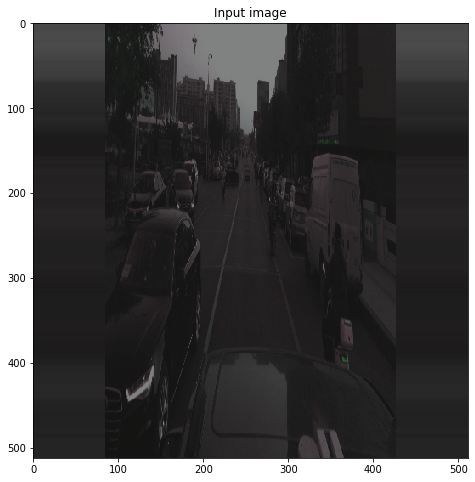

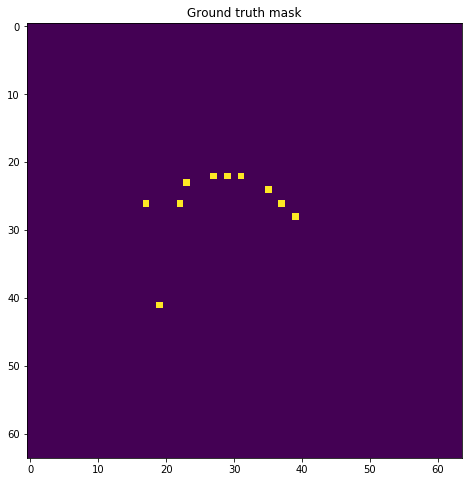

In [125]:
mean,std = [0.2732385,0.28948802,0.31470126],[0.19721317,0.20766443,0.20611505] #train 
# mean,std =[0.26370072,0.28066522,0.30648127],[0.19954063,0.20964707,0.2084653 ] #test
mean,std = np.array(mean), np.array(std)

def denormalize(img):
    img = transforms.Normalize(-1*mean/std, 1/std)(img) #denormalize
    return img

img, mask, regr = train_dataset[0]
# img, mask, regr = val_dataset[0]
# img, _ = test_dataset[1]

size = 8
plt.figure(figsize=(size,size))
plt.title('Input image')

img_show = denormalize(img).permute(1,2,0).cpu().numpy()
up = np.max(img_show)
low = np.min(img_show)
print(up,low)
plt.imshow(img_show)
plt.show()

plt.figure(figsize=(size,size))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

# img = img[None]  #(1,3,512,512),  img[None] = img[np.newaxis]
# print(np.shape(img))
# with torch.no_grad():
#     output = model(img.to(device))  #(1,8,64,256)
#     logits = output[0][0].data.cpu().numpy()      

# print(output.size())
# print(np.max(logits))

# plt.figure(figsize=(size,size))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()

# plt.figure(figsize=(size,size))
# plt.title('Model predictions thresholded')
# plt.imshow(logits > 0)
# plt.show()

# 2d to 3d inference test

In [18]:
DISTANCE_THRESH_CLEAR = 2

img = imread("./dataset/train_images/{}.jpg".format(train['ImageId'].iloc[0]))
IMG_SHAPE = img.shape

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction,logits_thresh=0):
    logits = prediction[0]
    regr_output = prediction[1:]
#     print("logits min:", np.min(logits), " logits max: ", np.max(logits))
    points = np.argwhere(logits > logits_thresh)
    
#     plt.figure(figsize=(15,6))
#     seaborn.countplot(np.array(logits).reshape(-1,1).squeeze(1))
#     plt.pause(.1)
#     stop
    
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

# Show Inference result on real Image

In [ ]:
# torch.cuda.empty_cache()
# gc.collect()
data_len = len(train_pd)
test_pd = pd.read_csv("./dataset/sample_submission.csv")

if __name__ == '__main__':
    with torch.no_grad():
        for i in range(105,115):
#             img, mask, regr = val_dataset[i]
            img, _ = test_dataset[i]
            
            img = img.to(device).unsqueeze(0)
            output = model(img).cpu().numpy()
#             coords_pred = extract_coords(output[0],logits_thresh=-1.25)
            coords_pred = extract_coords(output[0],logits_thresh=0)
            coords_true = extract_coords(np.concatenate([mask[None], regr], 0))

            offset = int(data_len*(1-vr))
            offset = 0
            idx = i+offset
#             img_origin = imread("./dataset/train_images/{}.jpg".format(train_pd['ImageId'].iloc[idx]))
            img_origin = imread("./dataset/test_images/{}.jpg".format(test_pd['ImageId'].iloc[idx]))
            print(test_pd['ImageId'].iloc[idx])

            print("ground true shape", np.shape(coords_true))
            print("pred shape", np.shape(coords_pred))
        #     print(coords_true)
        #     print("")
        #     print(coords_pred)
            fig, axes = plt.subplots(1,2, figsize=(16,16))
            axes[0].set_title('Ground truth')
            axes[0].imshow(visualize(img_origin, coords_true))
            axes[1].set_title('Prediction')
            axes[1].imshow(visualize(img_origin, coords_pred))
            plt.pause(.1)

# Submission

In [19]:
ths = [-0.05,-0.1,-0.15,-0.2]
model = CentResnet(8)
model.cuda()
model.load_state_dict(torch.load("./saved_model/Ep6_loss8.2134"))
model.eval()

for threshold in ths:
    predictions = []
    test_pd = pd.read_csv("./dataset/sample_submission.csv")
    indices_len = len(test_pd)
    print("indices_len",indices_len)
    test_dataset = TestDataset(data_len=indices_len)
    test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=0)
    with torch.no_grad():
        for img,_ in tqdm(test_loader):
            img = img.to(device)
            output = model(img).cpu().numpy()
            for out in output:
                coords = extract_coords(out,logits_thresh=threshold)
                s = coords2str(coords)
                predictions.append(s)

    print(np.shape(predictions))
    test = pd.read_csv(PATH + 'sample_submission.csv')
    test['PredictionString']= predictions
    file_name = "predictions_th{}.csv".format(threshold)
    test.to_csv(file_name, index=False)
    test.head()        

  0%|                                                  | 0/506 [00:00<?, ?it/s]

indices_len 2021


  0%|                                                  | 0/506 [00:00<?, ?it/s]

(2021,)
indices_len 2021


  0%|                                                  | 0/506 [00:00<?, ?it/s]

(2021,)
indices_len 2021


  0%|                                                  | 0/506 [00:00<?, ?it/s]

(2021,)
indices_len 2021


100%|████████████████████████████████████████| 506/506 [11:53<00:00,  1.41s/it]

(2021,)
